<center><img src="https://github.com/hse-ds/iad-applied-ds/blob/master/2021/hw/hw1/img/logo_hse.png?raw=1" width="1000"></center>

<h1><center>Прикладные задачи анализа данных</center></h1>
<h2><center>Домашнее задание 2: deep learning для обработки звука</center></h2>

# Введение

В этом задании Вы поработаете и разберетесь в деталях с форматами представления аудиоданных в задачах глубинного обучения, а так же напишете несколько моделей для классификации аудиозаписей.

В процессе выполнения Вы познакомитесь:
* С алгоритмом построения Мел-спектрограммы
* Рекуррентными и сверточными классификаторами аудиоданных
* Алгоритмом аугментации аудиоданных SpecAugment

In [1]:
!pip install torch==1.11.0 torchaudio==0.11.0 numpy==1.22


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 750.6/750.6 MB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 48.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 51.0 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 2.2.1+cu121
    Uninstalling torch-2.2.1+cu121:
      Successfully uninstalled torch-2.2.1+cu121
  Attempting uninstall: numpy
    Found existing installation: numpy 1.25.2
    Uninstalling numpy-1.25.2:
      Successfully uninstalled numpy-1.25.2
  Attempting uninstall: torchaudio
    Found existing installation: torchaudio 2.2.1+cu121
    Uninstalling torchaudio-2.2.1+cu121:
      Successfully uninstalled torchaudio-2.2.1+cu121
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
chex 0.1.86 requires numpy>=1.24.1, but you have numpy 1.22.0 which is incompati

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sn
import torch
import torchaudio
from IPython import display
from IPython.display import clear_output
from sklearn.metrics import confusion_matrix
from torch import nn
from torch.utils.data import DataLoader, Dataset, Subset
import librosa


%matplotlib inline

assert torch.__version__.startswith("1.11.0")
assert torchaudio.__version__.startswith("0.11.0")


device = "cuda:0"

# Классификация аудиозаписей.

В этом домашнем задании Вам предстоит классифицировать аудиозаписи из датасета [UrbanSound8K](https://urbansounddataset.weebly.com/urbansound8k.html).

Данный датасет состоит из 8732 записей, разбитых на train/val/test датасеты.

![image](https://paperswithcode.com/media/datasets/UrbanSound8K-0000003722-02faef06.jpg)

Каждая аудиозапись содержит запись шума города и принадлежит одному из 10 классов:

`[air_conditioner, car_horn, children_playing, dog_bark, drilling, engine_idling, gun_shot, jackhammer, siren, street_music]`


## Задание 1 (1 балл). Знакомство с данными.

- Скачайте датасет из [Google Drive](https://drive.google.com/drive/folders/1Q1mgopM_aQToKdSRlTI9zFW83sOqvrCS?usp=sharing) c и распакуйте в папку `./data`.
- Положите разархивированные данные рядом с юпитерской тетрадкой. Если вы работаете в колабе, залейте данные на свой гугл-диск и воспользуйтесь кодом ниже для синхронизации тетрадки с ним (это поможет не подгружать их по 10 раз).

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


- Напишите `AudioDataset` класс, который будет принимать путь к файлам `train_part.csv` и `val_part.csv` и возращать тройки объектов `(x, y, len)`, где `x` - аудиозапись, `y` - класс аудиозаписи, `len` - длина аудиозаписи. Аудиозаписи **не должны постоянно храниться в RAM**, подгрузку _wav_ файлов надо сделать при запросе через `__getitem__` метод. Кроме того, надо сделать паддинг аудиозаписи - если она короче чем `pad_size` параметр, надо дополнять ее нулями.

- С помощью функции `display.Audio` проиграйте в ноутбуке пару аудиозаписей.

In [3]:
!rm -r ./data
!mkdir ./data/
!pip install gdown
!unzip ./drive/MyDrive/HW2_dataset -d ./data

rm: cannot remove './data': No such file or directory
unzip:  cannot find or open ./drive/MyDrive/HW2_dataset, ./drive/MyDrive/HW2_dataset.zip or ./drive/MyDrive/HW2_dataset.ZIP.


In [4]:

classes = [
    "air_conditioner",
    "car_horn",
    "children_playing",
    "dog_bark",
    "drilling",
    "engine_idling",
    "gun_shot",
    "jackhammer",
    "siren",
    "street_music",
]

In [15]:
class AudioDataset(Dataset):
    def __init__(self, path_to_csv: str,
                 path_to_folder: str,
                 pad_size: int=384000,
                 sr: int = 44100):
        self.csv: pd.DataFrame = pd.read_csv(path_to_csv)[['ID', 'Class']]
        self.path_to_folder = path_to_folder
        self.pad_size = pad_size

        self.sr = sr

        self.class_to_idx = {classes[i]: i for i in range(10)}

    def __getitem__(self, index: int):
        row = self.csv.iloc[index]
        y = self.class_to_idx[row['Class']]
        if len(row) != 0:
          x, sr = librosa.load(self.path_to_folder + '/' + str(row['ID']) + '.wav', sr = self.sr)
        else:
          x = np.array([])
        if len(x) < self.pad_size:
          pad_x = np.concatenate([x, np.array([0]*(self.pad_size - len(x)))])
        else:
          pad_x = x
        return {'x': torch.from_numpy(pad_x).float(), 'y': y, 'len': len(x)}

    def __len__(self):
        return self.csv.shape[0]


In [16]:
train_dataset = AudioDataset(
    "/content/drive/MyDrive/data/urbansound8k/train_part.csv",
    "/content/drive/MyDrive/data/urbansound8k/data"
)
val_dataset = AudioDataset(
    "/content/drive/MyDrive/data/urbansound8k/val_part.csv",
    "/content/drive/MyDrive/data/urbansound8k/data"
)

Директория ./data удалена
Директория ./data создана


In [17]:

assert len(train_dataset) == 4500
assert len(val_dataset) == 935

In [18]:

item = train_dataset.__getitem__(0)

assert item["x"].shape == (384000,)
assert item["y"] == 0
assert item["len"] == 176400


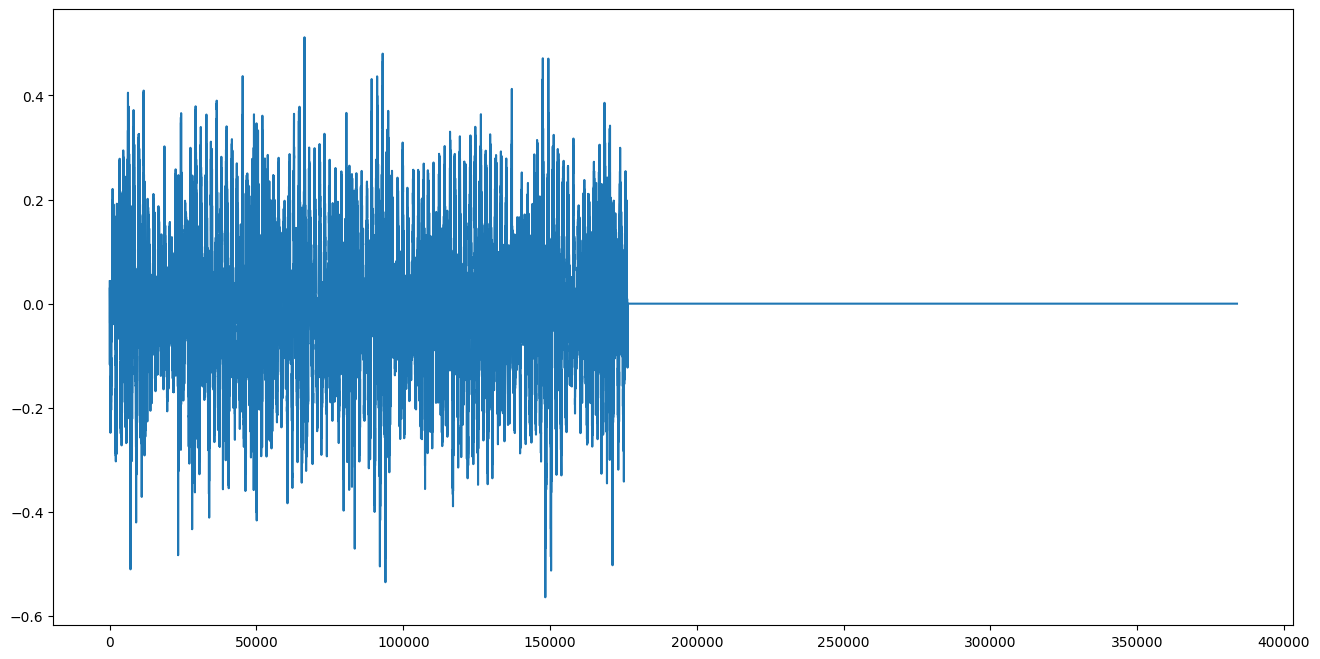

In [19]:

item = train_dataset.__getitem__(0)
plt.figure(figsize=(16, 8))
plt.plot(item["x"])

display.Audio(item["x"], rate=train_dataset.sr)

In [20]:

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, pin_memory=True, drop_last=True)  # Уменьшенный размер пакета

val_dataloader = DataLoader(val_dataset, batch_size=32, pin_memory=True)

## Задание 2. Рекуррентная сеть для классификации аудиозаписей по сырому сигналу (2 балла)

По своей сути аудиозапись является ни чем иным, как временным рядом - замеры микрофона делаются через равные промежутки времени и хранятся в виде последовательности.

Как известно, рекуррентные сети отлично подходят для работы с различными последовательностями, в том числе и с временными рядами.

Обучим простую реккурентную сеть для классификации аудиозаписей.

1. Разбейте аудизаписить на окошки размером `1024` с шагом `256`. Для этих целей отлично подойдет метод `torch.Tensor.unfold`.
1. Применим к каждому получившемуся окну аудиосигнала полносвязную сеть с активациями `ReLU` и  внутренними размерностям `(1024 -> 256 -> 64 -> 16)`.
2. По получившимся последовательностям пройдемся двунаправленой (`bidirectional=True`) LSTM с двумя слоями (`layers=2`).
3. Склеим c помощью `torch.cat` последние `hidden_state` для каждого слоя и применим к ним полносвязную сеть `(2 * hidden_size * num_layers -> 256 -> 10)` с активацией `ReLU`.

<center>
<img src="https://raw.githubusercontent.com/hse-ds/iad-applied-ds/2020-2023/2022/hw/hw2/imgs/rnn_raw.png" height="500">
</center>

*Совет*: для убыстрения обучения имеет смысл в полносвязные сети добавить `BatchNorm`.

In [21]:
import torch
import torch.nn as nn

class RecurrentRawAudioClassifier(nn.Module):
    def __init__(self, num_classes=10, window_length=1024, hop_length=256, hidden=256, num_layers=2):
        super().__init__()
        self.window_length = window_length; self.hop_length = hop_length
        self.first_mlp = nn.Sequential(nn.Linear(window_length, hidden), nn.ReLU(), nn.BatchNorm1d(hidden), nn.Linear(hidden, 64), nn.ReLU(), nn.BatchNorm1d(64), nn.Linear(64, 16), nn.ReLU())
        self.rnn = nn.LSTM(input_size=16, hidden_size=hidden, num_layers=2, bidirectional=True)
        self.final_mlp = nn.Sequential(nn.Linear(2 * hop_length * num_layers, hidden), nn.ReLU(), nn.BatchNorm1d(hidden), nn.Linear(hidden, num_classes), nn.ReLU())

    def forward(self, x, lens):
        batch_windows = x.unfold(1, 1024, 256)
        batch_windows_feautures = torch.stack(list(map(self.first_mlp, batch_windows))).permute(1,0,2)
        output, (hidden_state, state) = self.rnn(batch_windows_feautures)
        hidden_flattened = torch.stack(list(map(torch.flatten, hidden_state.permute(1, 0, 2))))
        return self.final_mlp(hidden_flattened)


Обучим получившуюся модель.

In [62]:
def train_audio_clfr(
    model,
    optimizer,
    train_dataloader,
    sr,
    criterion=torch.nn.CrossEntropyLoss(),
    data_transform=None,
    augmentation=None,
    num_epochs=10,
    device="cuda:0",
    verbose_num_iters=10,
):
    model.train()
    iter_i = 0
    train_losses = []
    train_accuracies = []

    for epoch in range(num_epochs):
        for batch in train_dataloader:
            try:
                x = batch["x"].to(device)
                y = batch["y"].to(device)
                lens = batch["len"].to(device)

                if data_transform:
                    x, lens = data_transform(x, lens, device=device, sr=sr)
                if augmentation:
                    x, lens = augmentation(x, lens)
                probs = model(x, lens)
                optimizer.zero_grad()
                loss = criterion(probs, y)
                loss.backward()
                optimizer.step()
                train_losses.append(loss.item())
                pred_cls = probs.argmax(dim=-1)
                train_accuracies.append((pred_cls == y).float().mean().item())
                iter_i += 1
                if iter_i % verbose_num_iters == 0:
                    clear_output(wait=True)
                    print(f"Epoch {epoch}")

                    plt.figure(figsize=(10, 5))
                    plt.subplot(1, 2, 1)
                    plt.xlabel("Iteration")
                    plt.ylabel("Train loss")
                    plt.plot(np.arange(iter_i), train_losses)

                    plt.subplot(1, 2, 2)
                    plt.xlabel("Iteration")
                    plt.ylabel("Train acc")
                    plt.plot(np.arange(iter_i), train_accuracies)

                    plt.show()
            except Exception as e:
                print(f"Error processing batch: {e}")

    model.eval()


In [23]:
# создадим объекты модели и оптимизатор
rnn_raw = RecurrentRawAudioClassifier()
rnn_raw.to(device)
optim = torch.optim.Adam(rnn_raw.parameters(), lr=3e-4)

Epoch 9


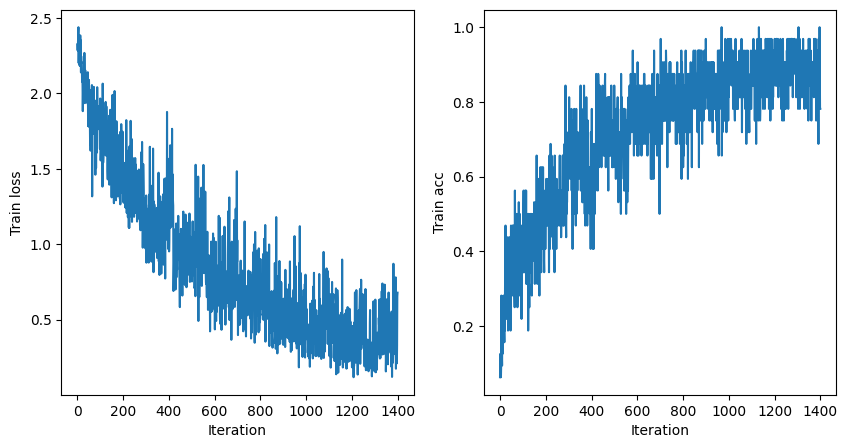

In [24]:
# обучим модель
train_audio_clfr(rnn_raw, optim, train_dataloader, train_dataset.sr)

Посчитаем метрики на валидационном датасете.

In [25]:
def plot_confusion_matrix(model, val_dataloader, sr, device, data_transform=None):
    pred_true_pairs = []
    for batch in val_dataloader:
        x = batch["x"].to(device)
        y = batch["y"].to(device)
        lens = batch["len"].to(device)

        with torch.no_grad():
            if data_transform:
                x, lens = data_transform(x, lens, sr=sr, device=device)

            probs = model(x, lens)

            pred_cls = probs.argmax(dim=-1)

        for pred, true in zip(pred_cls.cpu().detach().numpy(), y.cpu().numpy()):
            pred_true_pairs.append((pred, true))

    print(f"Val accuracy: {np.mean([p[0] == p[1] for p in pred_true_pairs])}")

    cm_df = pd.DataFrame(
        confusion_matrix(
            [p[1] for p in pred_true_pairs],
            [p[0] for p in pred_true_pairs],
            normalize="true",
        ),
        columns=classes,
        index=classes,
    )
    sn.heatmap(cm_df, annot=True)

Val accuracy: 0.17967914438502675


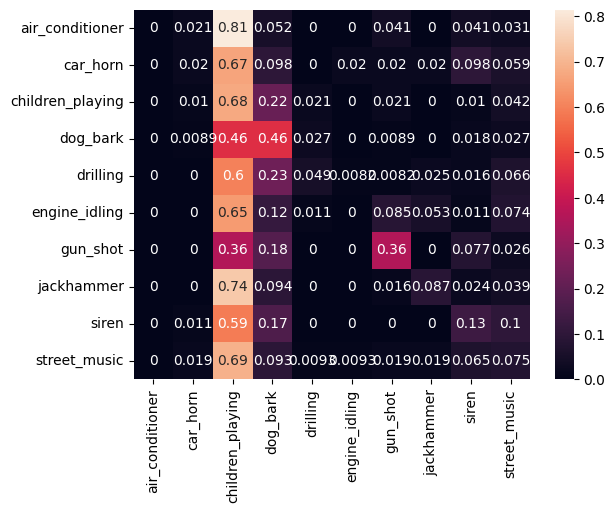

In [26]:
plot_confusion_matrix(rnn_raw, val_dataloader, train_dataset.sr, device)

*Вопрос* : Сильно ли отличается качество модели на тренировочной и валидационной выборке? Если да, то как думаете, в чем причина?

На валидационной выборке ьыла низкая точность (17.97%), поэтому можно предположить, что модель страдает от переобучения. Основные причины могут включать недостаточную репрезентативность тренировочных данных, переобучение из-за слишком сложной модели, шум в данных, недостаточную регуляризацию и несбалансированные классы

## Задание 3. Построение Мел-cпектрограмм. (2 балла)

Сырой сигнал очень чувствителен ко многим факторам - увеличение/уменьшение громкости, внешние шумы, сменение тембра говорящего очень резко меняют сырой сигнал. Это влияет и на качество глубоких сетей, обученных на сыром аудиосигнале.

Для построения надежных и устойчивых к переобучению моделей используют другое представление аудиоданных - спектрограммы, в том числе Мел-спектрограмму.

Идея её построения заключается в следующем:
1. Сигнал разбивается на временные интервалы (с пересечениями)
2. К каждому временному интервалу применяется фильтр (как правило косинусоидальный)
3. К профильтрованному сигналу применяется дискретное преобразование Фурье и вычисляются спектральные признаки сигнала.
4. Спектральные признаки с помощью логарифмического преобразования приводятся в Мел-шкалу.

<center>
<img src="https://antkillerfarm.github.io/images/img2/Spectrogram_5.png" height="550">
</center>

В этом задании мы сами шаг за шагом напишем алгоритм построения мелспектрограммы и сравнимся с референсной функцией из `torchaudio`.

In [27]:
from torchaudio.transforms import MelSpectrogram


# референсная функця
def compute_log_melspectrogram_reference(wav_batch, lens, sr, device="cpu"):
    featurizer = MelSpectrogram(
        sample_rate=sr,
        n_fft=1024,
        win_length=1024,
        hop_length=256,
        n_mels=64,
        center=False,
    ).to(device)

    return torch.log(featurizer(wav_batch).clamp(1e-5)), lens // 256

<ipython-input-27-75d74d9d609f>:15: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  return torch.log(featurizer(wav_batch).clamp(1e-5)), lens // 256


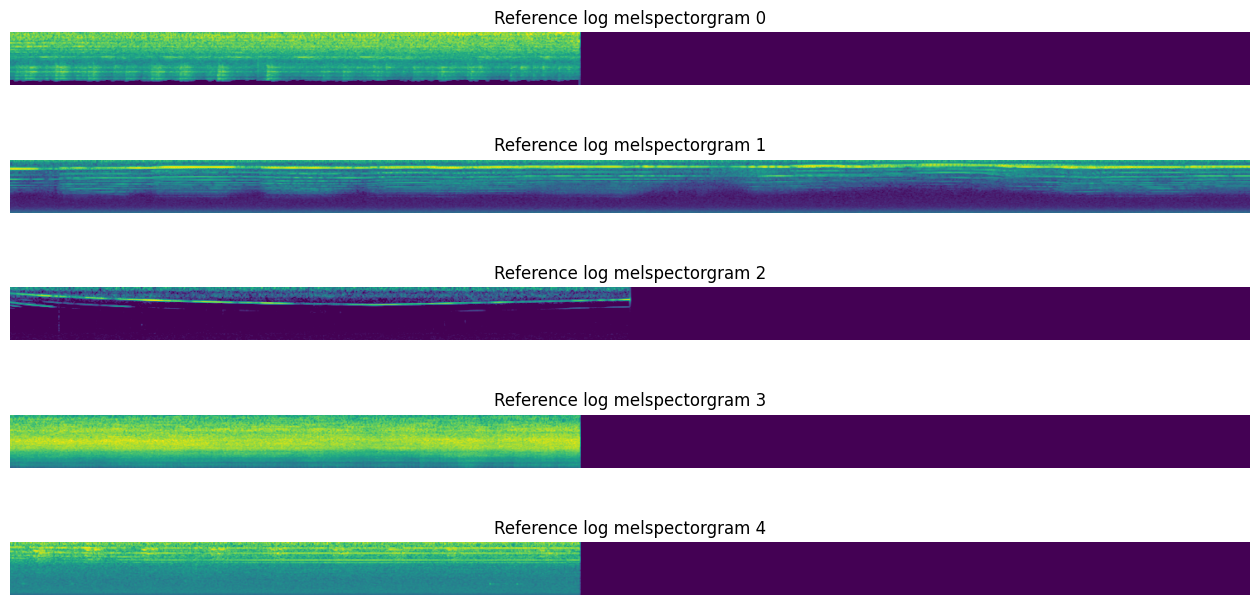

In [28]:
# возьмем случайный батч
for batch in train_dataloader:
    break

wav_batch = batch["x"]
lens = batch["len"]

# посчитаем лог мелспектрограммы
log_melspect, lens = compute_log_melspectrogram_reference(
    wav_batch, lens, train_dataset.sr
)

# нарисуем получившиеся референсные значения
fig, axes = plt.subplots(5, figsize=(16, 8))

for i in range(5):
    axes[i].axis("off")
    axes[i].set_title(f"Reference log melspectorgram {i}")
    axes[i].imshow(log_melspect[i].numpy())

Теперь сделаем то же самое сами.

In [29]:
sr = train_dataset.sr
n_fft = 1024
win_length = 1024
hop_length = 256
n_mels = 64


Для начала с помощью метода `unfold` разделим аудиосигнал на окна размера `win_lenght` через промежутки `hop_lenght`.

In [30]:
windows = wav_batch.unfold(1, win_length, hop_length)
assert windows.shape == (32, 1497, 1024)

Нарисуем и проиграем сигнал из одного окна.

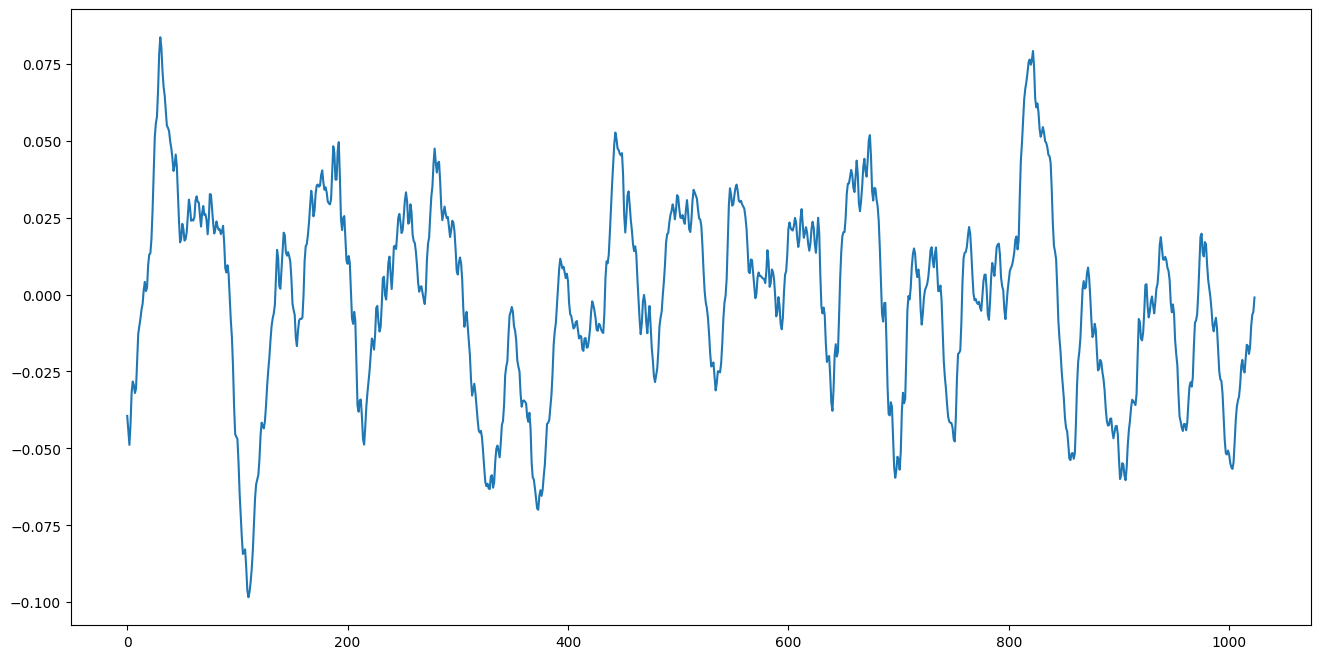

In [31]:
plt.figure(figsize=(16, 8))
plt.plot(windows[0, 0])

display.Audio(windows[0, 0], rate=train_dataset.sr)

Теперь нам надо применить косинуисальный фильтр к сигналу из окна. Для этого с помощью `torch.hann_window` создадим косинусоидальный фильтр и умножим его поэлементно на все окна.

In [32]:

windows = windows.to(device)

filter = torch.hann_window(win_length).to(device)

windows_with_applied_filter = windows * filter[None, None, :]


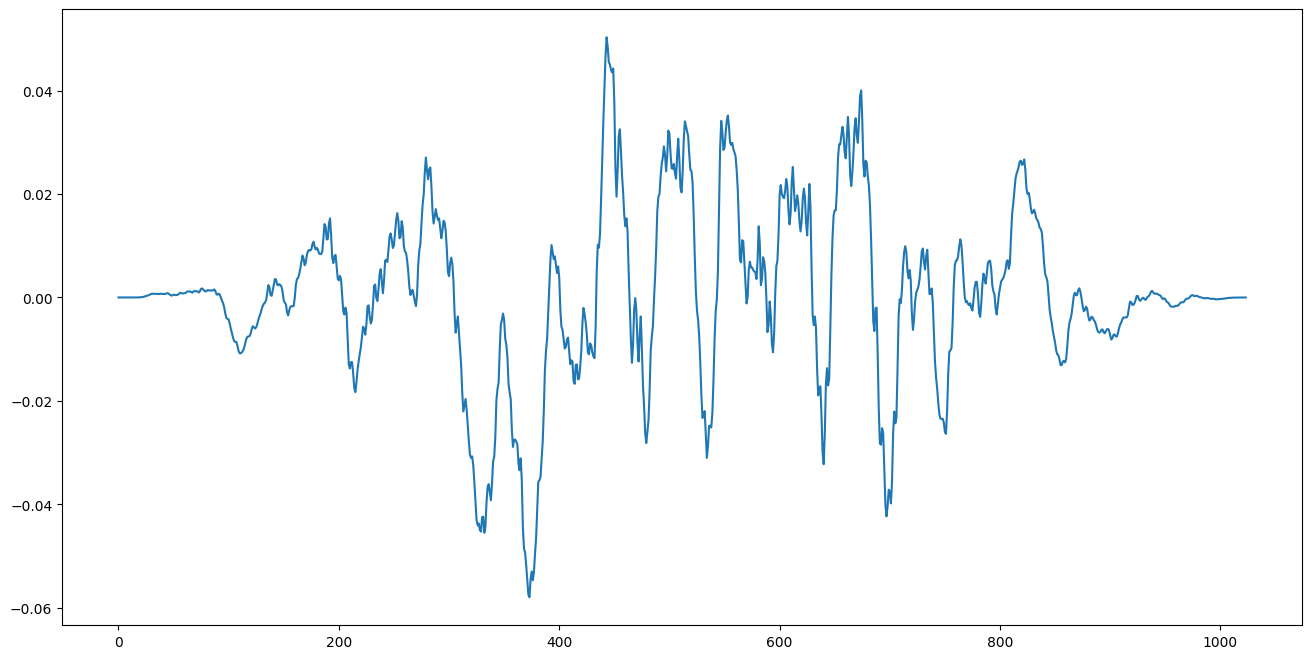

In [33]:
plt.figure(figsize=(16, 8))
plt.plot(windows_with_applied_filter[0, 0].cpu().numpy())
display.Audio(windows_with_applied_filter[0, 0].cpu().numpy(), rate=train_dataset.sr)


С помощью `torch.fft.fft` примените дискретное преобразование фурье к каждому окну и возьмите первые `n_fft // 2 + 1` компоненты.

Дальше с помощью возведения элементов тензора в квадрат и `torch.abs()` получите магнитуды.

NameError: name 'fft_magnitudes' is not defined

Через `torchaudio.transforms.MelScale` создайте класс для перевода магнитуд в Мел-шкалу.

In [34]:
n_fft = 512
n_mels = 64
sr = 44100
fft_features = torch.fft.fft(windows_with_applied_filter, n=n_fft)
fft_magnitudes = torch.abs(fft_features[..., :n_fft // 2 + 1]**2)
melscale = torchaudio.transforms.MelScale(n_mels, sr, n_stft=n_fft // 2 + 1).to(device)
mel_spectrogram = melscale(fft_magnitudes.transpose(1, 2))
print("FFT magnitudes shape:", fft_magnitudes.shape)
print("Mel spectrogram shape:", mel_spectrogram.shape)

FFT magnitudes shape: torch.Size([32, 1497, 257])
Mel spectrogram shape: torch.Size([32, 64, 1497])


/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:507: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (64) may be set too high. Or, the value for `n_freqs` (257) may be set too low.
  warnings.warn(


Нелинейное преобразование для перевода в Мел-шкалу выглядит следующим образом.

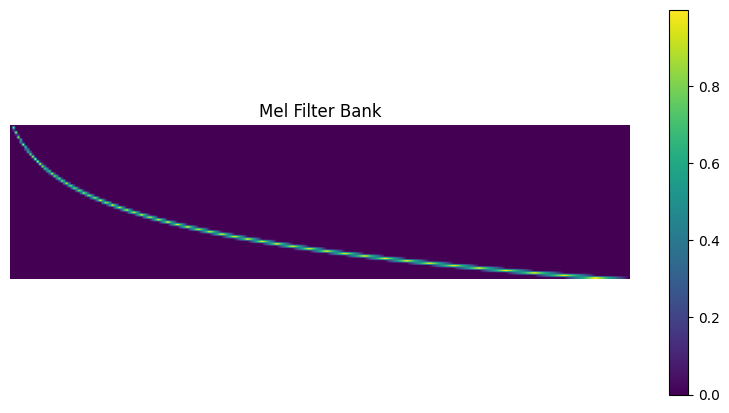

In [35]:
plt.figure(figsize=(10, 5))
plt.axis("off")
plt.imshow(melscale.fb.cpu().numpy().transpose())
plt.title("Mel Filter Bank")
plt.colorbar()
plt.show()


Примените Мел-шкалу к магнитудам.

In [36]:

fft_magnitudes = fft_magnitudes.transpose(1, 2)

mel_spectrogram = melscale(fft_magnitudes)

print("Post-transpose FFT magnitudes shape:", fft_magnitudes.shape)
print("Mel spectrogram shape:", mel_spectrogram.shape)
print("Device fft_magnitudes:", fft_magnitudes.device)
print("Device filter bank:", melscale.fb.device)
fft_magnitudes = fft_magnitudes.to(device)


Post-transpose FFT magnitudes shape: torch.Size([32, 257, 1497])
Mel spectrogram shape: torch.Size([32, 64, 1497])
Device fft_magnitudes: cuda:0
Device filter bank: cuda:0


Сделайте обрезку значений по `1e-5` и примените `torch.log` для получения логарифмированной Мел-спектрограммы.

In [37]:
logmel_spectrogram = torch.log(mel_spectrogram.clamp(min=1e-5))

assert logmel_spectrogram.shape == (32, 64, 1497)

Полученные логарифмированные Мел-Спектрограммы должны совпадать с референсными.

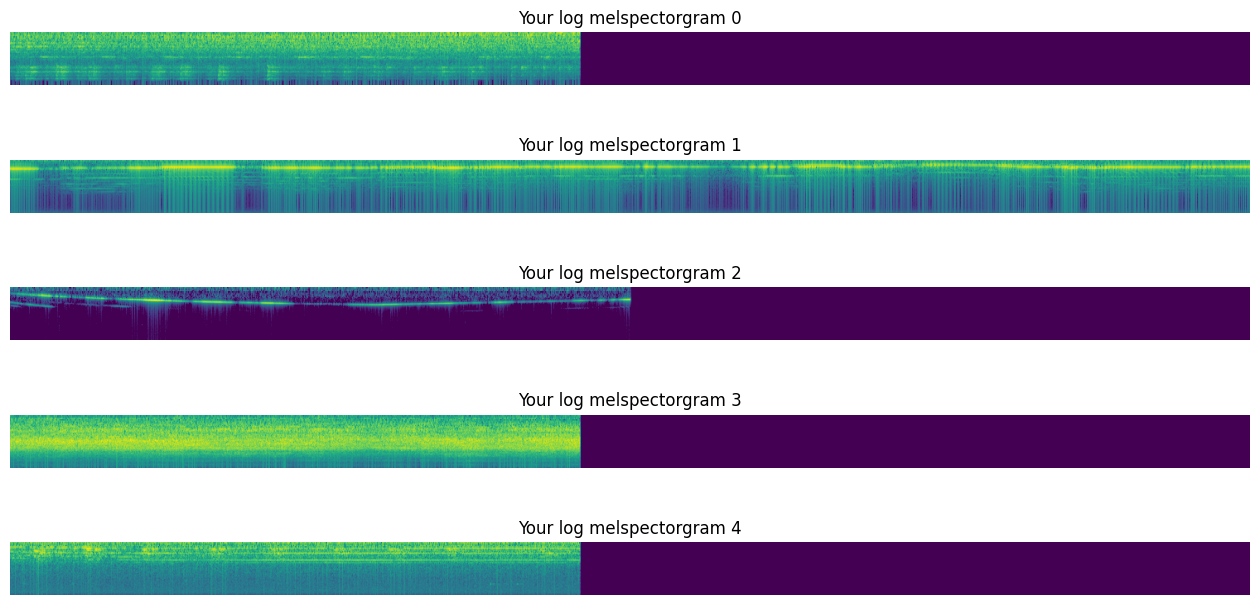

In [38]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(5, figsize=(16, 8))

for i in range(5):
    axes[i].axis("off")
    axes[i].set_title(f"Your log melspectorgram {i}")
    axes[i].imshow(logmel_spectrogram[i].cpu().numpy())


Теперь оформим эту логику в функцию.

In [39]:
# ваша реализация
def compute_log_melspectrogram(wav_batch, lens, sr, device="cpu"):
    windows = wav_batch.unfold(1, win_length, hop_length)
    filter = torch.hann_window(win_length).to(device)
    windows_with_applied_filter = windows * filter[None, None, :]
    fft_features = torch.fft.fft(windows_with_applied_filter)
    fft_magnitudes = torch.abs(fft_features[:, :, :n_fft // 2 + 1]**2)
    melscale = torchaudio.transforms.MelScale(n_mels, sr, n_fft=n_fft).to(device)
    mel_spectrogram = melscale(fft_magnitudes)
    logmel_spectrogram = torch.log(mel_spectrogram.clamp(min=1e-5))
    return logmel_spectrogram, lens // hop_length


Финальная проверка.

In [40]:
def compute_log_melspectrogram(wav_batch, lens, sr, device="cpu"):
    win_length = 1024
    hop_length = 256
    n_fft = 1024
    n_mels = 64

    windows = wav_batch.unfold(1, win_length, hop_length).to(device)
    filter = torch.hann_window(win_length, device=device)
    windows_with_applied_filter = windows * filter[None, None, :]

    fft_features = torch.fft.fft(windows_with_applied_filter, n=n_fft)
    fft_magnitudes = torch.abs(fft_features[..., :n_fft // 2 + 1]**2)

    melscale = torchaudio.transforms.MelScale(n_mels, sr, n_stft=n_fft // 2 + 1).to(device)
    mel_spectrogram = melscale(fft_magnitudes.transpose(1, 2))

    logmel_spectrogram = torch.log(mel_spectrogram.clamp(min=1e-5))
    reduced_lens = torch.div(lens, hop_length, rounding_mode='floor')

    return logmel_spectrogram, reduced_lens

result, result_lens = compute_log_melspectrogram(wav_batch, lens, train_dataset.sr, device)
print("Mel spectrogram shape:", result.shape)
print("Reduced lens:", result_lens)


assert torch.allclose(
    compute_log_melspectrogram_reference(wav_batch, lens, train_dataset.sr)[0],
    compute_log_melspectrogram(wav_batch, lens, train_dataset.sr)[0],
    atol=1e-5,
)

Mel spectrogram shape: torch.Size([32, 64, 1497])
Reduced lens: tensor([2, 5, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 0, 2, 2, 2, 5, 2, 5, 0, 2, 2, 2,
        1, 2, 2, 2, 2, 2, 2, 2])


<ipython-input-27-75d74d9d609f>:15: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  return torch.log(featurizer(wav_batch).clamp(1e-5)), lens // 256


## Задание 4. Рекуррентная сеть для классификации аудиозаписей по логарифмированным Мел-спектрограммам (1 балл)

Измените реализацию рекуррентной сети из задания 2, таким образом, чтобы она вместо сырого сигнала смогла принимать логарифмированные Мел-спетрограммы:
1. Уберите шаги 1-2
2. Сделайте вход LSTM равным 64

<center>
<img src="https://raw.githubusercontent.com/hse-ds/iad-applied-ds/2020-2023/2022/hw/hw2/imgs/rnn_mel.png" height="500">
</center>

**За реализацию архитектуры дается 0.5 балла.**

In [41]:
class RecurrentMelSpectClassifier(nn.Module):
  def __init__(self, num_classes=10, window_length=1024, hop_length=256, hidden=256, num_layers=2):
    super().__init__()
    self.window_length = window_length
    self.hop_length = hop_length
    self.rnn = nn.LSTM(input_size=64, hidden_size=hidden, num_layers=2, bidirectional=True)
    self.final_mlp = nn.Sequential(nn.Linear(2 * hop_length * num_layers, hidden), nn.ReLU(), nn.BatchNorm1d(hidden), nn.Linear(hidden, num_classes), nn.ReLU())
  def forward(self, x, lens):
    batch_windows = x
    batch_windows_feautures = batch_windows.permute(2, 0, 1)
    output, (hidden_state, state) = self.rnn(batch_windows_feautures)
    hidden_flattened = torch.stack(list(map(torch.flatten, hidden_state.permute(1, 0, 2))))
    return self.final_mlp(hidden_flattened)

In [42]:
rnn_mel = RecurrentMelSpectClassifier()
rnn_mel.to(device);

optim = torch.optim.Adam(rnn_mel.parameters(), lr=1e-4)

Epoch 19


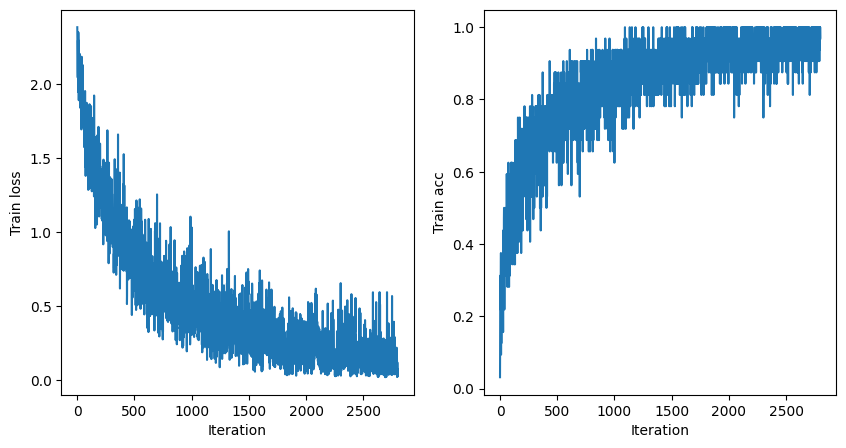

In [43]:
train_audio_clfr(rnn_mel, optim, train_dataloader, train_dataset.sr,
                 data_transform=compute_log_melspectrogram,
                 num_epochs=20)

Посчитаем метрики на валидационном датасете.

**Задание: для получения 0.5 балла сделайте подбор гиперпараметров и добейтесь accuracy модели выше 0.8 на валидационном датасете.**

Val accuracy: 0.8588235294117647


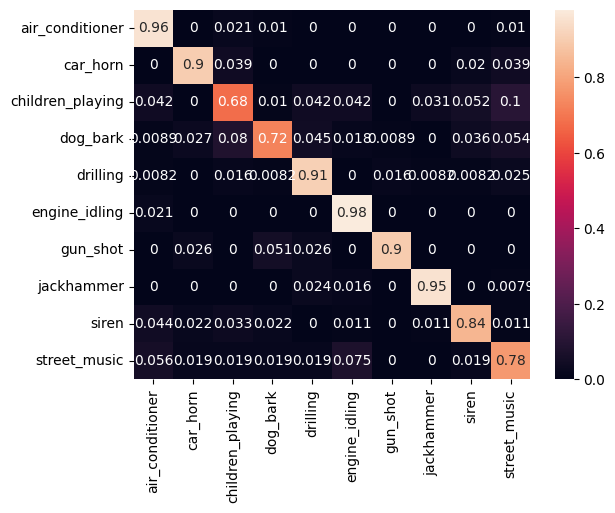

In [44]:
plot_confusion_matrix(
    rnn_mel,
    val_dataloader,
    train_dataset.sr,
    device,
    data_transform=compute_log_melspectrogram,
)

## Задание 5. Cверточная сеть для классификации аудиозаписей по мелспектрограммам. (2 балла)

Легко заметить, что мелспектрограммы имеют четко выраженные паттерны - если приноровиться, то даже человек, посмотрев на мелспектрограмму, сможет _визуально_ проклассифицировать объект.

Это позволяет свести задачу классификации аудиозаписей к задаче классификации картинок.

Реализуем такую сверточную сеть:

* 2x (Conv2d 3x3 @ 16, BatchNorm2d, ReLU)
* MaxPoll 2x2
* 2x (Conv2d 3x3 @ 32, BatchNorm2d, ReLU)
* MaxPoll 2x2
* 2x (Conv2d 3x3 @ 64, BatchNorm2d, ReLU)
* MaxPoll 2x2
* (Conv2d 3x3 @ 128, BatchNorm2d, ReLU)
* (Conv2d 2x2 @ 128, BatchNorm2d, ReLU)
* Global MaxPoll
* Fully Connected 128, ReLU
* Fully Connected 10

Совет: подобная архитектура была реализована в [**PANNs: Large-Scale Pretrained Audio Neural Networks for Audio Pattern Recognition**](https://arxiv.org/pdf/1912.10211.pdf), можете использовать эту статью как референс.


**За реализацию архитектуры дается 1.5 балла.**

In [52]:
import torch
import torch.nn as nn

class CNN10(nn.Module):
    def __init__(self, num_classes=10, hidden=16):
        super().__init__()

        self.cnn_backbone = nn.Sequential(
            nn.Conv2d(1, hidden, kernel_size=3, padding=1),
            nn.BatchNorm2d(hidden),
            nn.ReLU(),
            nn.Conv2d(hidden, hidden, kernel_size=3, padding=1),
            nn.BatchNorm2d(hidden),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(hidden, hidden * 2, kernel_size=3, padding=1),
            nn.BatchNorm2d(hidden * 2),
            nn.ReLU(),
            nn.Conv2d(hidden * 2, hidden * 2, kernel_size=3, padding=1),
            nn.BatchNorm2d(hidden * 2),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(hidden * 2, hidden * 4, kernel_size=3, padding=1),
            nn.BatchNorm2d(hidden * 4),
            nn.ReLU(),
            nn.Conv2d(hidden * 4, hidden * 4, kernel_size=3, padding=1),
            nn.BatchNorm2d(hidden * 4),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(hidden * 4, hidden * 8, kernel_size=3, padding=1),
            nn.BatchNorm2d(hidden * 8),
            nn.ReLU(),
            nn.Conv2d(hidden * 8, hidden * 8, kernel_size=2, padding=1),
            nn.BatchNorm2d(hidden * 8),
            nn.ReLU()
        )

        # Полносвязный слой для классификации
        self.final_mlp = nn.Sequential(
            nn.Linear(hidden * 8, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x, lens):
        # Применяем сверточную часть сети
        z = self.cnn_backbone(x[:, None, :, :])  # Добавляем канал

        # Применяем глобальный MaxPool
        z = nn.functional.max_pool2d(z, kernel_size=z.size()[2:])[:, :, 0, 0]

        # Полносвязный слой для классификации
        return self.final_mlp(z)

# Инициализируем модель и оптимизатор
cnn = CNN10()
cnn.to(device)
optim = torch.optim.Adam(cnn.parameters(), lr=3e-4)

# Обучаем модель
train_audio_clfr(
    cnn,
    optim,
    train_dataloader,
    train_dataset.sr,
    data_transform=compute_log_melspectrogram,
    num_epochs=20
)


In [53]:
cnn = CNN10()
cnn.to(device);

optim = torch.optim.Adam(cnn.parameters(), lr=3e-4)

Epoch 19


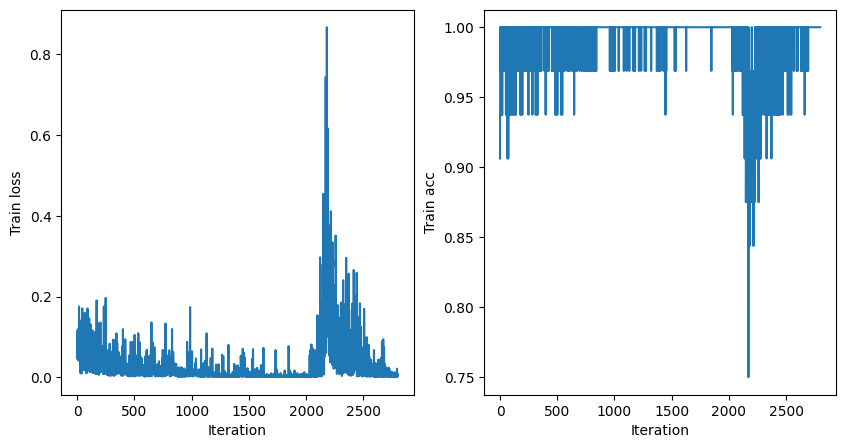

In [65]:
train_audio_clfr(cnn, optim, train_dataloader, train_dataset.sr,
                 data_transform=compute_log_melspectrogram,
                 num_epochs=20)

**Задание: для получения 0.5 балла сделайте подбор гиперпараметров и добейтесь accuracy модели выше 0.85 на валидационном датасете.**

Val accuracy: 0.9572192513368984


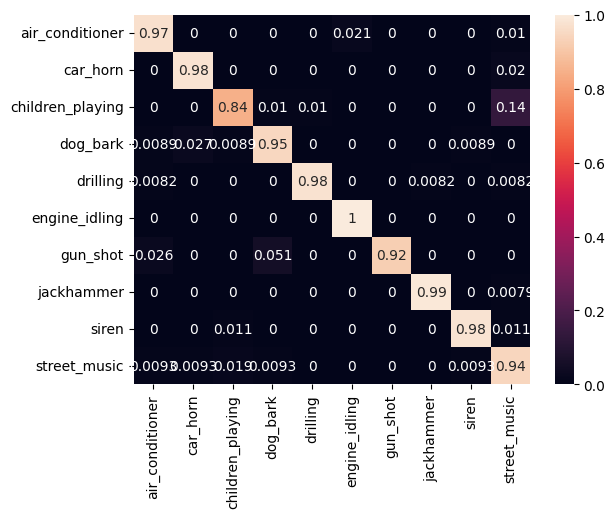

In [66]:
plot_confusion_matrix(
    cnn,
    val_dataloader,
    train_dataset.sr,
    device,
    data_transform=compute_log_melspectrogram,
)

## Задание 6. Аугментация SpecAugment (2 балла)

Обычно датасеты с аудиозаписями довольно малы. Наш датасет тому пример - всего 4500 объектов в обучающей выборке. Обучение глубокий сетей с большим кол-вом параметров на таких датасетах часто ведет к переобучению и проседанию метрик на валидационном и тестовом датасетах.

Для борьбы с переобучением имеет смысл использовать аугментацию данных. Для мелспектрограмм была придумана аугментация под названием SpecAugment.

Смысл её очень прост - зануление спектрограммы по временным промежуткам и по мел-частотам:
1. Выбираются несколько временных промежутков ${[t^1_i, t^2_i]}$ и заполняют спектрограмму $s[t^1_i : t^2_i, :]$ значением $v$.

2. Выбираются несколько промежутков мелчастот ${[m^1_i, m^2_i]}$ и заполняют спектрограмму $s[:, m^1_i : m^2_i]$ значением $v$.

В качестве значения $v$ выбирают:
1. `'mean'`: среднее по спектрограмме
2. `'min'`: минимум по спектрограмме
3. `'max'`: максимум по спектрограмме
5. `v`: некоторая константа

Совет: описание аугментации можно найти здесь: [link](https://neurohive.io/ru/novosti/specaugment-novyj-metod-augmentacii-audiodannyh-ot-google-ai/), можете использовать эту ссылку как референс.

![specaugment](https://neurohive.io/wp-content/uploads/2019/04/image6.png)

В этом задании Вам предлагается реализовать аугментацию SpecAugment.

**За реализацию аугментации дается 1.5 балла.**


In [55]:
import random

class SpectAugment:
    def __init__(
        self,
        filling_value="mean",
        n_freq_masks=2,
        n_time_masks=2,
        max_freq=10,
        max_time=50,
    ):
        self.filling_value = filling_value
        self.n_freq_masks = n_freq_masks
        self.n_time_masks = n_time_masks
        self.max_freq = max_freq
        self.max_time = max_time

    def apply_mask(self, spect, start, end, dim):
        if self.filling_value == 'mean':
            fill_value = spect.mean()
        elif self.filling_value == 'min':
            fill_value = spect.min()
        elif self.filling_value == 'max':
            fill_value = spect.max()
        else:
            fill_value = float(self.filling_value)
        if dim == 1:
            spect[:, start:end] = fill_value
        else:
            spect[start:end, :] = fill_value

    def __call__(self, spect, lens):
        for _ in range(self.n_freq_masks):
            freq_band = random.randint(0, self.max_freq)
            f0 = random.randint(0, spect.shape[1] - freq_band)
            self.apply_mask(spect, f0, f0 + freq_band, 1)

        for _ in range(self.n_time_masks):
            time_band = random.randint(0, self.max_time)
            t0 = random.randint(0, spect.shape[2] - time_band)
            self.apply_mask(spect, t0, t0 + time_band, 2)

        return spect, lens

spect_augment = SpectAugment()

<ipython-input-27-75d74d9d609f>:15: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  return torch.log(featurizer(wav_batch).clamp(1e-5)), lens // 256


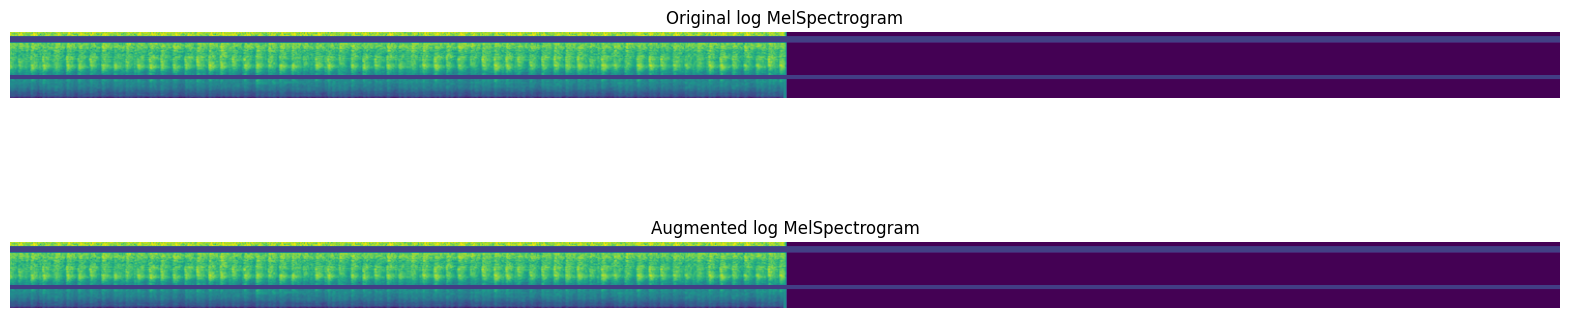

In [59]:
# применим аугментацию к данным
for batch in train_dataloader:
  break

x = batch['x'].to(device)
lens = batch['len'].to(device)
x_logmel, lens = compute_log_melspectrogram_reference(x, lens, sr=train_dataset.sr, device=device)
x_logmel_augmented, lens = SpectAugment()(x_logmel, lens)

# нарисуем спектрограмму до и после аугментации
plt.figure(figsize=(20, 5))
plt.subplot(2, 1, 1)
plt.title('Original log MelSpectrogram')
plt.axis('off')
plt.imshow(x_logmel[0].cpu().numpy())

plt.subplot(2, 1, 2)
plt.title('Augmented log MelSpectrogram')
plt.axis('off')
plt.imshow(x_logmel_augmented[0].cpu().numpy())

In [60]:
cnn = CNN10()
cnn.to(device)

optim = torch.optim.Adam(cnn.parameters(), lr=3e-4)

Epoch 19


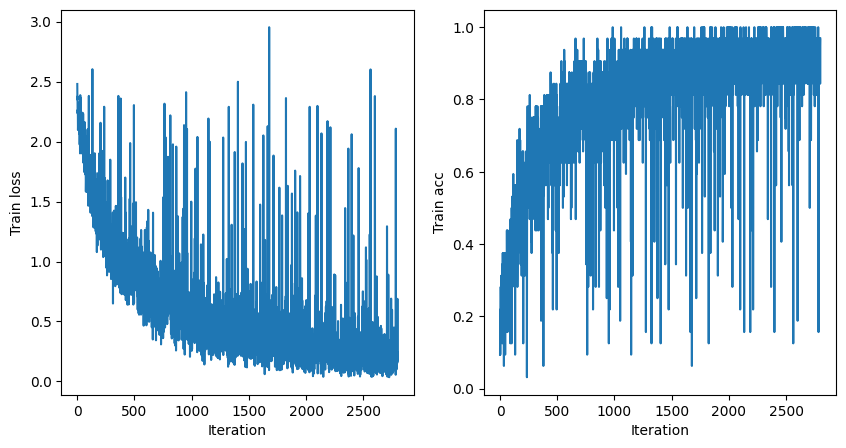

In [63]:
# обучим модель на данных с аугментациями
train_audio_clfr(
    cnn,
    optim,
    train_dataloader,
    train_dataset.sr,
    data_transform=compute_log_melspectrogram,
    augmentation=SpectAugment(),
    num_epochs=20,
)

**Задание: для получения 0.5 балла сделайте подбор параметров аугментации и добейтесь accuracy модели выше 0.9 на валидационном датасете.**

Val accuracy: 0.9262032085561497


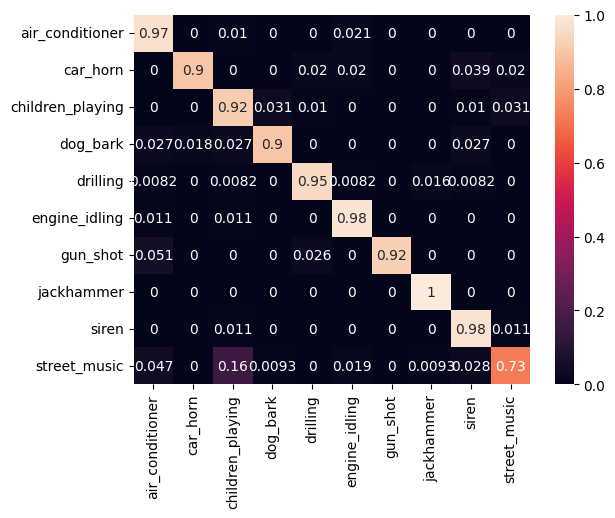

In [64]:
plot_confusion_matrix(
    cnn,
    val_dataloader,
    train_dataset.sr,
    device,
    data_transform=compute_log_melspectrogram,
)